In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [2]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.datasets as datasets
import imageio
import numpy as np
from torchvision.utils import make_grid, save_image
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from tqdm import tqdm

In [3]:
# learning parameters

batch_size = 512
epochs = 100
sample_size = 64 # fixed sample size for generator
nz = 128 # latent vector size
k = 1 # number of steps to apply to the discriminator
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,)),
])
to_pil_image = transforms.ToPILImage()

# Make input, output folders

!mkdir -p /content/drive/MyDrive/ML_CS760/Homework_6/input_2
!mkdir -p /content/drive/MyDrive/ML_CS760/Homework_6/output_2

# Load train data

train_data = datasets.MNIST(
    root='/content/drive/MyDrive/ML_CS760/Homework_6/input_2/data',
    train=True,
    download=True,
    transform=transform
)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 123257046.93it/s]


Extracting /content/drive/MyDrive/ML_CS760/Homework_6/input_2/data/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/ML_CS760/Homework_6/input_2/data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 148087645.26it/s]


Extracting /content/drive/MyDrive/ML_CS760/Homework_6/input_2/data/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/ML_CS760/Homework_6/input_2/data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 39302653.35it/s]


Extracting /content/drive/MyDrive/ML_CS760/Homework_6/input_2/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/ML_CS760/Homework_6/input_2/data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8497113.63it/s]

Extracting /content/drive/MyDrive/ML_CS760/Homework_6/input_2/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/ML_CS760/Homework_6/input_2/data/MNIST/raw



In [5]:
class Generator(nn.Module):

    def __init__(self, nz):
        super(Generator, self).__init__()
        self.nz = nz
        self.main = nn.Sequential(
            nn.Linear(self.nz, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 784),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)

In [6]:
class Discriminator(nn.Module):

    def __init__(self):
        super(Discriminator, self).__init__()
        self.n_input = 784
        self.main = nn.Sequential(
            nn.Linear(self.n_input, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 784)
        return self.main(x)

In [7]:
generator = Generator(nz).to(device)
discriminator = Discriminator().to(device)
print('##### GENERATOR #####')
print(generator)
print('######################')
print('\n##### DISCRIMINATOR #####')
print(discriminator)
print('######################')

##### GENERATOR #####
Generator(
  (main): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=256, out_features=512, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=512, out_features=1024, bias=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=1024, out_features=784, bias=True)
    (7): Tanh()
  )
)
######################

##### DISCRIMINATOR #####
Discriminator(
  (main): Sequential(
    (0): Linear(in_features=784, out_features=1024, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Dropout(p=0.3, inplace=False)
    (9): Linear(in_features=256, out_features=1

In [8]:
# optimizers

optim_g = optim.Adam(generator.parameters(), lr=0.0002)
optim_d = optim.Adam(discriminator.parameters(), lr=0.0002)

# loss function

criterion = nn.BCELoss() # Binary Cross Entropy loss
losses_g = [] # to store generator loss after each epoch
losses_d = [] # to store discriminator loss after each epoch
images = [] # to store images generatd by the generator

In [9]:
# to create real labels (1s)

def label_real(size):
    data = torch.ones(size, 1)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size, 1)
    return data.to(device)

# function to create the noise vector
def create_noise(sample_size, nz):
    return torch.randn(sample_size, nz).to(device)

# to save the images generated by the generator
def save_generator_image(image, path):
    save_image(image, path)

# create the noise vector - fixed to track how GAN is trained.
noise = create_noise(sample_size, nz)

In [10]:
torch.manual_seed(7777)

def generator_loss(output, true_label):
    return torch.sum(torch.log(true_label - output)) / torch.sum(true_label)

def discriminator_loss(output, true_label):
    return criterion(output, true_label)

118it [00:20,  5.77it/s]                         


Epoch 1 of 100
Generator loss: -0.24830567, Discriminator loss: 0.43727666


118it [00:13,  8.45it/s]                         


Epoch 2 of 100
Generator loss: -0.00004319, Discriminator loss: 0.00007011


118it [00:15,  7.49it/s]                         


Epoch 3 of 100
Generator loss: -0.00004977, Discriminator loss: 0.00007251


118it [00:14,  8.03it/s]                         


Epoch 4 of 100
Generator loss: -0.00005628, Discriminator loss: 0.00007881


118it [00:15,  7.44it/s]                         


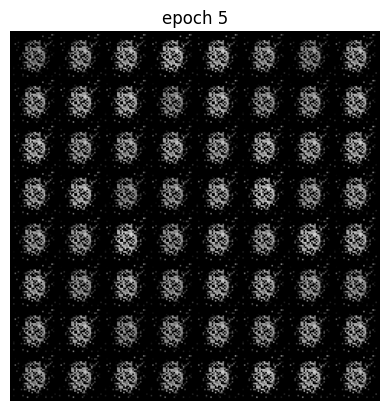

Epoch 5 of 100
Generator loss: -0.00014240, Discriminator loss: 0.00016632


118it [00:15,  7.87it/s]                         


Epoch 6 of 100
Generator loss: -0.00028374, Discriminator loss: 0.00515835


118it [00:14,  7.98it/s]                         


Epoch 7 of 100
Generator loss: -0.00003623, Discriminator loss: 0.00015799


118it [00:14,  7.92it/s]                         


Epoch 8 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  7.87it/s]                         


Epoch 9 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  6.99it/s]                         


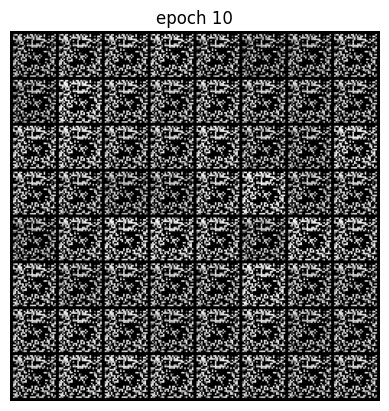

Epoch 10 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.69it/s]                         


Epoch 11 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  7.96it/s]                         


Epoch 12 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  7.96it/s]                         


Epoch 13 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:14,  7.90it/s]                         


Epoch 14 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:14,  7.88it/s]                         


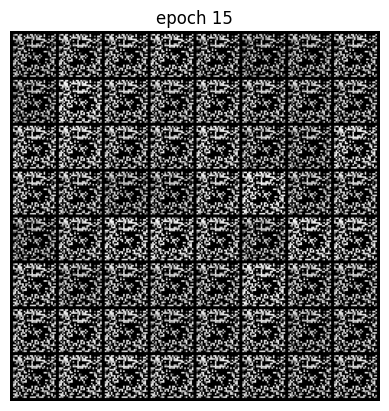

Epoch 15 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.67it/s]                         


Epoch 16 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.69it/s]                         


Epoch 17 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.57it/s]                         


Epoch 18 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.66it/s]                         


Epoch 19 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.54it/s]                         


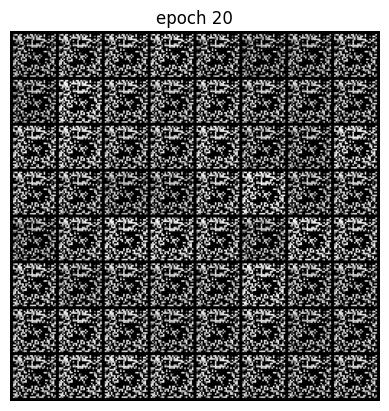

Epoch 20 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.49it/s]                         


Epoch 21 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.66it/s]                         


Epoch 22 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.75it/s]                         


Epoch 23 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.82it/s]                         


Epoch 24 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.63it/s]                         


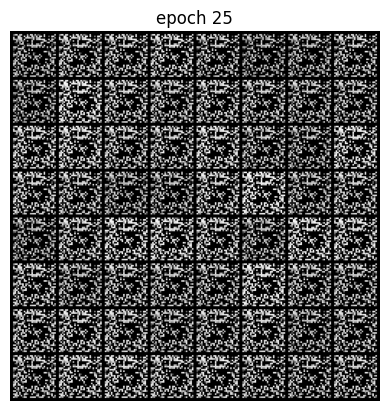

Epoch 25 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.67it/s]                         


Epoch 26 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.60it/s]                         


Epoch 27 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.45it/s]                         


Epoch 28 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.48it/s]                         


Epoch 29 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.40it/s]                         


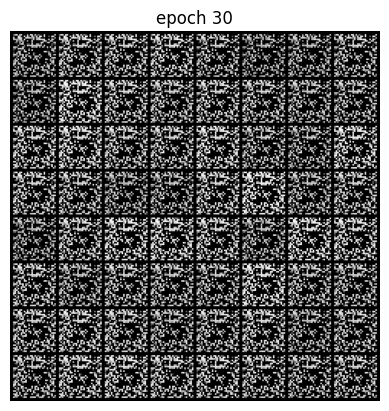

Epoch 30 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.59it/s]                         


Epoch 31 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.28it/s]                         


Epoch 32 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.32it/s]                         


Epoch 33 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.30it/s]                         


Epoch 34 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.52it/s]                         


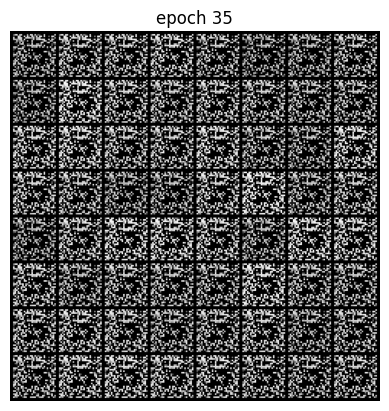

Epoch 35 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.46it/s]                         


Epoch 36 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.57it/s]                         


Epoch 37 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.46it/s]                         


Epoch 38 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.23it/s]                         


Epoch 39 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.27it/s]                         


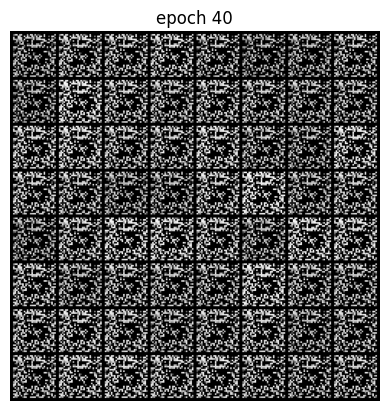

Epoch 40 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.19it/s]                         


Epoch 41 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.12it/s]                         


Epoch 42 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.14it/s]                         


Epoch 43 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.13it/s]                         


Epoch 44 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.18it/s]                         


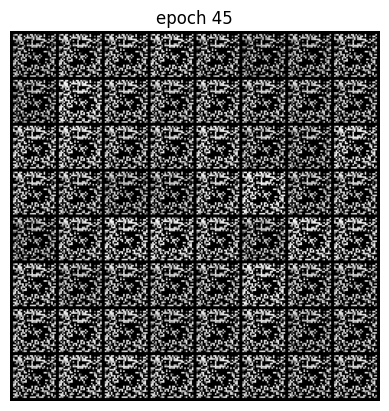

Epoch 45 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  6.99it/s]                         


Epoch 46 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.26it/s]                         


Epoch 47 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:15,  7.39it/s]                         


Epoch 48 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.25it/s]                         


Epoch 49 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.18it/s]                         


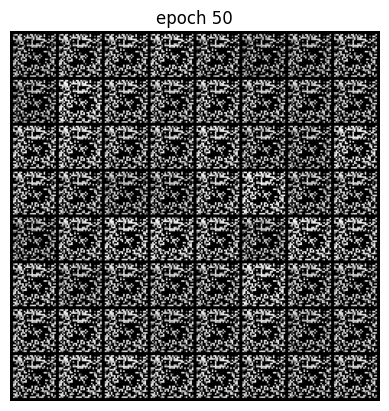

Epoch 50 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:18,  6.31it/s]                         


Epoch 51 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.19it/s]                         


Epoch 52 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.88it/s]                         


Epoch 53 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.00it/s]                         


Epoch 54 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.07it/s]                         


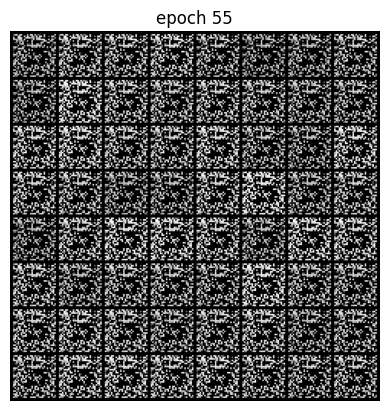

Epoch 55 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.93it/s]                         


Epoch 56 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  6.98it/s]                         


Epoch 57 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.93it/s]                         


Epoch 58 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.08it/s]                         


Epoch 59 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.93it/s]                         


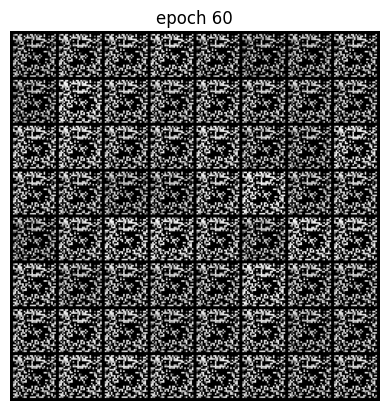

Epoch 60 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.03it/s]                         


Epoch 61 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.15it/s]                         


Epoch 62 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.94it/s]                         


Epoch 63 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.86it/s]                         


Epoch 64 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.86it/s]                         


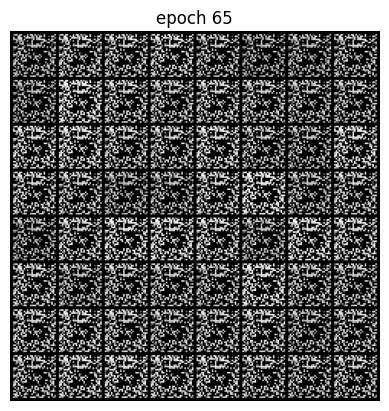

Epoch 65 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.78it/s]                         


Epoch 66 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.70it/s]                         


Epoch 67 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.02it/s]                         


Epoch 68 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:16,  7.04it/s]                         


Epoch 69 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:19,  6.13it/s]                         


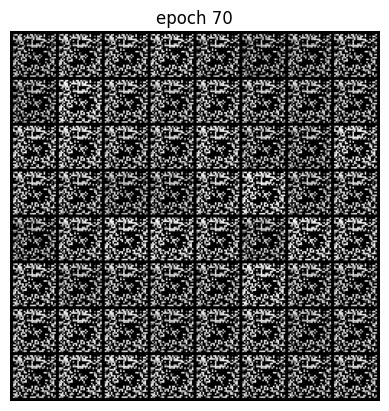

Epoch 70 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.80it/s]                         


Epoch 71 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.58it/s]                         


Epoch 72 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.62it/s]                         


Epoch 73 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.58it/s]                         


Epoch 74 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.73it/s]                         


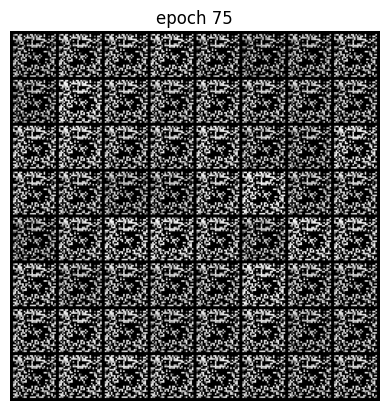

Epoch 75 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.68it/s]                         


Epoch 76 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.82it/s]                         


Epoch 77 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.81it/s]                         


Epoch 78 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.83it/s]                         


Epoch 79 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.66it/s]                         


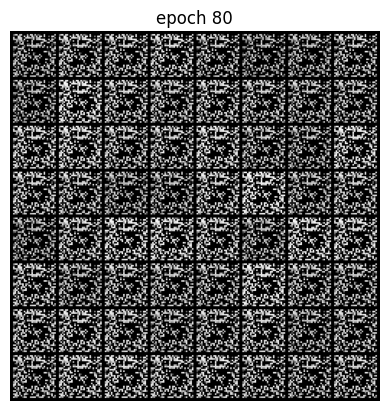

Epoch 80 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.58it/s]                         


Epoch 81 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:18,  6.53it/s]                         


Epoch 82 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.79it/s]                         


Epoch 83 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.79it/s]                         


Epoch 84 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.69it/s]                         


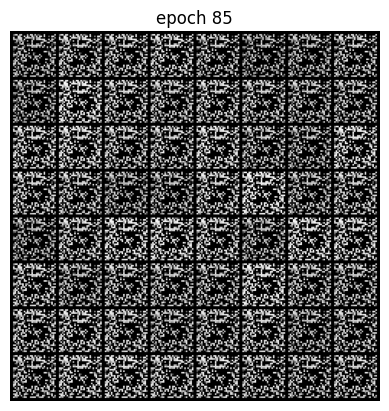

Epoch 85 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.67it/s]                         


Epoch 86 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.57it/s]                         


Epoch 87 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:20,  5.72it/s]                         


Epoch 88 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:18,  6.51it/s]                         


Epoch 89 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:18,  6.44it/s]                         


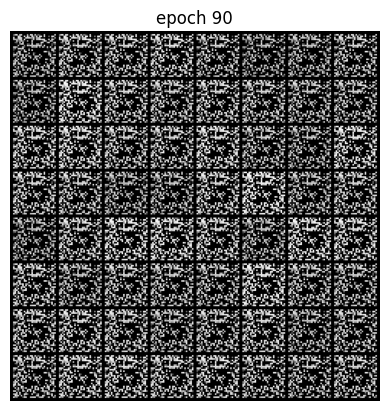

Epoch 90 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:18,  6.42it/s]                         


Epoch 91 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.64it/s]                         


Epoch 92 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.57it/s]                         


Epoch 93 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.60it/s]                         


Epoch 94 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:18,  6.44it/s]                         


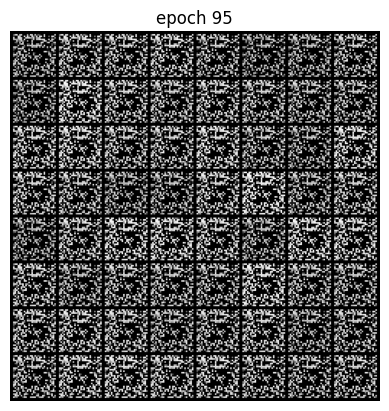

Epoch 95 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:18,  6.35it/s]                         


Epoch 96 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:18,  6.33it/s]                         


Epoch 97 of 100
Generator loss: 0.00000000, Discriminator loss: 0.00000000


118it [00:18,  6.31it/s]                         


Epoch 98 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:18,  6.46it/s]                         


Epoch 99 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000


118it [00:17,  6.64it/s]                         


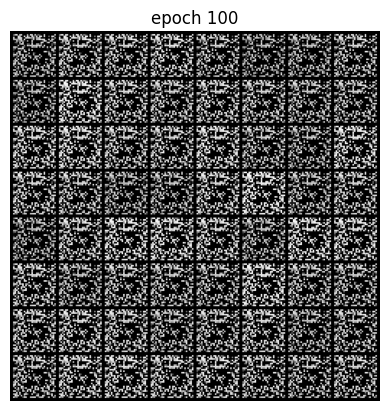

Epoch 100 of 100
Generator loss: -0.00000000, Discriminator loss: 0.00000000
DONE TRAINING


In [11]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    for bi, data in tqdm(enumerate(train_loader), total=int(len(train_data) / train_loader.batch_size)):

        x = data[0].to(device)

        optim_d.zero_grad()

        real_pass_output = discriminator.forward(x)
        d_pass_loss_real = discriminator_loss(real_pass_output, label_real(real_pass_output.size()[0]))

        fake_pass_data = generator.forward(create_noise(sample_size, nz))
        fake_pass_output = discriminator.forward(fake_pass_data)
        d_pass_loss_fake = discriminator_loss(fake_pass_output, label_fake(sample_size))

        loss_D = d_pass_loss_real + d_pass_loss_fake
        loss_D.backward()
        optim_d.step()

        loss_d += loss_D.item()

        optim_g.zero_grad()

        generated_data = generator.forward(create_noise(sample_size, nz))
        generated_output = discriminator.forward(generated_data)
        loss_G = generator_loss(generated_output, label_real(sample_size))

        loss_G.backward()
        optim_g.step()

        loss_g += loss_G.item()

    # Create the final fake image for the epoch
    generated_img = generator(noise).cpu().detach()

    # Make the images as a grid
    generated_img = make_grid(generated_img)

    # Visualize generated images
    if (epoch + 1) % 5 == 0:
        plt.imshow(generated_img.permute(1, 2, 0))
        plt.title(f'epoch {epoch+1}')
        plt.axis('off')
        plt.show()

    # Save the generated torch tensor models to disk
    save_generator_image(generated_img, f"/content/drive/MyDrive/ML_CS760/Homework_6/output_2/gen_img{epoch+1}.png")
    images.append(generated_img)
    epoch_loss_g = loss_g / bi  # Total generator loss for the epoch
    epoch_loss_d = loss_d / bi  # Total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)

    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")

print('DONE TRAINING')
torch.save(generator.state_dict(), '/content/drive/MyDrive/ML_CS760/Homework_6/output_2/opt_generator.pth')

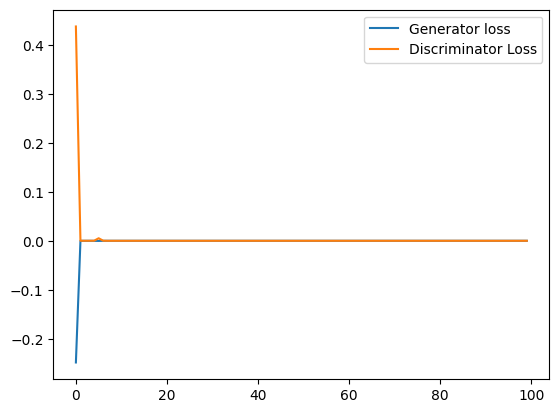

In [12]:
# save the generated images as GIF file
imgs = [np.array(to_pil_image(img)) for img in images]
imageio.mimsave('/content/drive/MyDrive/ML_CS760/Homework_6/output_2/opt_generator_images.gif', imgs)

# plot and save the generator and discriminator loss
plt.figure()
plt.plot(losses_g, label='Generator loss')
plt.plot(losses_d, label='Discriminator Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/ML_CS760/Homework_6/output_2/opt_loss.png')